## Random Forests

**Random Forest**
- Random Forest is an **ensemble model** built from many decision trees.  
- Each tree is trained on a random subset of the data and features ("bagging" + "feature randomness").  
- The final prediction is made by **majority vote** (classification) or **averaging** (regression).  
- This randomness makes the model more robust and reduces overfitting compared to a single decision tree.

**Why ?**
- Handles **non-linear relationships** and **feature interactions** automatically.  
- Works well on mixed or categorical-like features without strict scaling.  
- More powerful than Logistic Regression for complex patterns, are less sensitive to outliers than Logistic Regression.
- Built-in support for **imbalanced classes** using `class_weight="balanced"`.  

It will help us see whether non-linear ensembles improve performance.


In [8]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scripts.data_loader import load_caravan
from scripts.metrics import evaluate_model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [9]:
train, test, X, y, TARGET = load_caravan(data_dir="../data")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Class imbalance: use class_weight="balanced_subsample" so each tree sees reweighted classes
rf = RandomForestClassifier(
    n_estimators=400,           # number of trees
    max_depth=None,             # allow trees to grow fully (we regularize via min_samples_leaf)
    min_samples_leaf=2,         # small leaf size to reduce overfitting a bit
    min_samples_split=5,        # avoid very tiny splits
    class_weight="balanced_subsample", #same as “balanced” except weights are computed based on the bootstrap sample for every tree grown.
    n_jobs=-1,                  # use all CPU cores
    random_state=42
)

rf.fit(X_train, y_train)

proba_val = rf.predict_proba(X_val)[:, 1]
preds_val = rf.predict(X_val)

results = evaluate_model("random forest", y_val, proba_val)


=== random forest ===
ROC-AUC: 0.7161 | PR-AUC: 0.1425
Best-F1 threshold: 0.156
At best-F1: Precision=0.155, Recall=0.500, F1=0.237
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1643
           1       0.16      0.50      0.24       104

    accuracy                           0.81      1747
   macro avg       0.56      0.66      0.56      1747
weighted avg       0.92      0.81      0.85      1747



## Random Forest Results

**Global metrics**
- **ROC-AUC = 0.716** → The model has a reasonable ability to rank buyers above non-buyers.  
- **PR-AUC = 0.143** → On this imbalanced dataset (6% positives), this is about 2–3× better than random guessing (≈0.06).  

**Performance at best-F1 threshold (0.156)**
- **Precision = 0.155** → About 15% of predicted buyers are correct.  
- **Recall = 0.500** → The model successfully identifies 50% of the true buyers.  
- **F1 = 0.237** → Harmonic mean of precision and recall, balancing the two.  

**Classification report (per class)**
- **Class 0 (non-buyers)**: Precision 0.96, Recall 0.83 → the model is strong at detecting non-buyers.  
- **Class 1 (buyers)**: Precision 0.16, Recall 0.50 → the model catches half of the buyers, but with many false positives.  

**Accuracy = 0.81**  
- Looks decent, but less informative here because the dataset is highly imbalanced.  

**Interpretation**  
- Random Forest captures **half of the true buyers** but at the cost of many false alarms.  
- It performs better than random, but **precision is low**, meaning a marketing campaign would still contact many uninterested customers.  
- Compared to Logistic Regression and Gradient Boosting, this model is **weaker in PR-AUC and F1**, so it is not the best choice overall.


In [14]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

rf_base = RandomForestClassifier(
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

param_dist = {
    "n_estimators": randint(300, 901),     # 300..900
    "max_depth":   [None, 8, 10, 12, 14],  # discrete set (depth control helps ranking)
    "min_samples_leaf": randint(1, 5),     # 1..4
    "min_samples_split": randint(2, 11),   # 2..10
    "max_features": ["sqrt", "log2", None] # feature subsampling
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_rand = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True
)

rf_rand.fit(X_train, y_train)

print("Best RF params:", rf_rand.best_params_)
print("Best CV PR-AUC:", round(rf_rand.best_score_, 4))

rf_best = rf_rand.best_estimator_

# Evaluate tuned model on validation
proba_val_best = rf_best.predict_proba(X_val)[:, 1]
preds_val_best  = rf_best.predict(X_val)

results = evaluate_model("random forest (tuned) ", y_val, proba_val_best)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best RF params: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 500}
Best CV PR-AUC: 0.1674

=== random forest (tuned)  ===
ROC-AUC: 0.7664 | PR-AUC: 0.1973
Best-F1 threshold: 0.575
At best-F1: Precision=0.256, Recall=0.317, F1=0.283
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1643
           1       0.26      0.32      0.28       104

    accuracy                           0.90      1747
   macro avg       0.61      0.63      0.62      1747
weighted avg       0.91      0.90      0.91      1747



## Random Forest (Tuned) Results

- **ROC-AUC = 0.766** → The model can reasonably rank buyers vs. non-buyers.  
- **PR-AUC = 0.197** → Better than random baseline (~0.06), but still modest for an imbalanced dataset.  

- **Best-F1 threshold = 0.575**  
  - **Precision = 0.256** → ~26% of predicted buyers are correct.  
  - **Recall = 0.317** → ~32% of actual buyers are captured.  
  - **F1 = 0.283** → Balanced score, better then logistic regression.  

- **Class 0 (non-buyers)**: Very strong performance (precision/recall ≈ 0.95).  
- **Class 1 (buyers)**: Weak recall and precision, reflecting the challenge of imbalance.  
- **Accuracy = 0.90** looks high, but is dominated by the majority class and not a reliable indicator.  


In [15]:
# Refit final RF on ALL labeled data
rf_final = RandomForestClassifier(**rf_best.get_params())
rf_final.random_state = 42
rf_final.fit(X, y)

X_test = test.copy()
best_thr = 0.575

test_probabilities = rf_final.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

test_pred = (test_probabilities >= best_thr).astype(int)

# count and percentage
num_pred = int(test_pred.sum())
total = len(test_pred)
pct = 100.0 * num_pred / total

print(f"Number of customers predicted to be interested: {num_pred}")
print(f"Percentage of customers predicted to be interested: {pct:.2f}%")

Number of customers predicted to be interested: 307
Percentage of customers predicted to be interested: 7.67%


## Feature Importance

Gini importance measures how much each feature reduces impurity across all trees.
It is quick and widely used. They can be biased toward variables with many split points; they don’t show direction (increase vs decrease). Still useful as a global ranking

Top 10 Features Influencing Decisions:
                   Feature  Importance
 Contribution car policies    0.114173
         # of car policies    0.070468
Contribution fire policies    0.052724
          Customer Subtype    0.035408
     Lower level education    0.028070
            Average income    0.027545
           Income < 30.000    0.026814
    Purchasing power class    0.026199
        Customer main type    0.022939
                   Married    0.020946


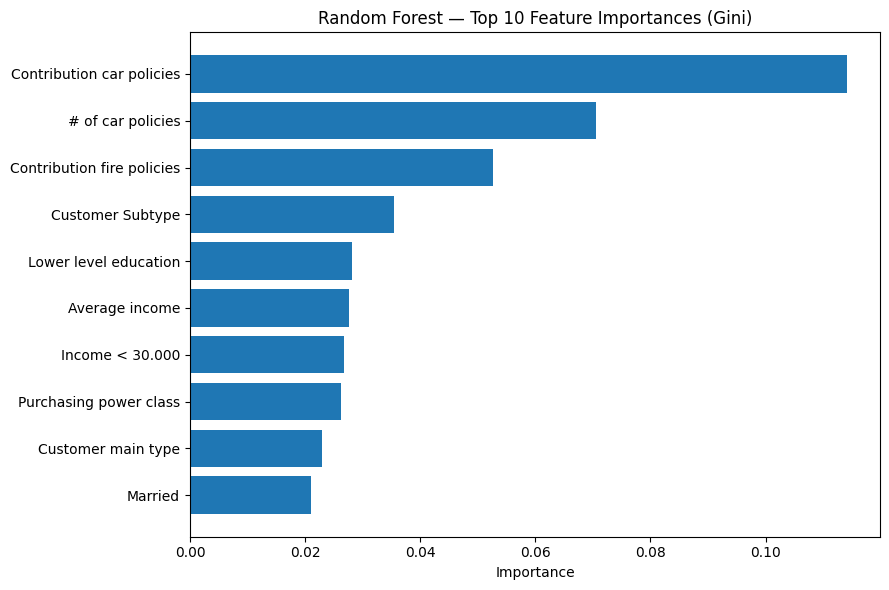

In [16]:
importances = pd.Series(rf_final.feature_importances_, index=X.columns).sort_values(ascending=False)
top10 = importances.head(10).reset_index()
top10.columns = ["Feature", "Importance"]

print("Top 10 Features Influencing Decisions:")
print(top10.to_string(index=False))

plt.figure(figsize=(9,6))
plt.barh(top10["Feature"][::-1], top10["Importance"][::-1])
plt.title("Random Forest — Top 10 Feature Importances (Gini)")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()

### Business Interpretation of Top Features

- **Contribution car policies / # of car policies** → Customers already insuring cars are more likely to add caravan insurance.  
- **Contribution fire policies** → House/property insurance holders show some interest in asset protection.  
- **Customer Subtype / Customer main type** → Household segmentation (lifestyle, demographics) strongly influences likelihood.  
- **Lower level education** → Socio-demographic signal that may correlate with income, risk preferences, or asset ownership.  
- **Average income / Income < 30,000 / Purchasing power class** → Financial capacity directly affects ability to buy discretionary insurance.  
- **Married** → Family status may drive demand for additional protection products like caravan insurance.  
